# Joint Modelling

In this tutorial you will learn how to set up a joint modelling fit which encoporates the data from multiple images. These use `Group_Model` objects just like in the `GroupModels.ipynb` tutorial, the main difference being how the `Target_Image` object is constructed and that more care must be taken when assigning targets to models.  

It is, of course, more work to set up a fit across multiple target images. However, the tradeoff can be well worth it. Perhaps there is space-based data with high resolution, but groundbased data has better S/N. Or perhaps each band individually does not have enough signal for a confident fit, but all three together just might. Perhaps colour information is of paramount importance for a science goal, one would hope that both bands could be treated on equal footing but in a consistent way when extracting profile information. There are a number of reasons why one might wish to try and fit a multi image picture of a galaxy simultaneously. 

When fitting multiple bands one often resorts to forced photometry, somtimes also blurring each image to the same approximate PSF. With AstroPhot this is entirely unecessary as one can fit each image in its native PSF simultaneously. The final fits are more meaningful and can encorporate all of the available structure information.

In [1]:
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from scipy.stats import iqr

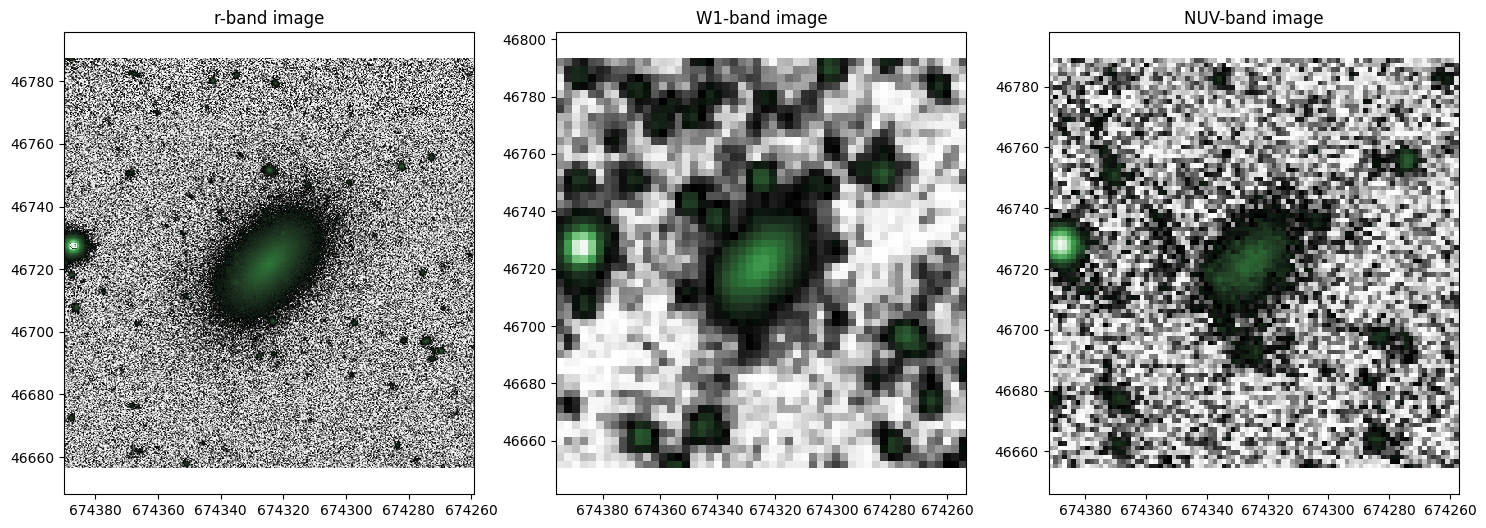

In [2]:
# First we need some data to work with, let's use LEDA 41136 as our example galaxy

# The images must be aligned to a common coordinate system. From the DESI Legacy survey we are extracting
# each image from a common center coordinate, so we set the center as (0,0) for all the images and they
# should be aligned.

# It is also important to have a good estimate of the variance and the PSF for each image since these
# affect the relative weight of each image. For the tutorial we use simple approximations, but in 
# science level analysis one should endeavor to get the best measure available for these.

# Our first image is from the DESI Legacy-Survey r-band. This image has a pixelscale of 0.262 arcsec/pixel and is 500 pixels across
lrimg = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=187.3119&dec=12.9783&size=500&layer=ls-dr9&pixscale=0.262&bands=r")
target_r = ap.image.Target_Image(
    data = np.array(lrimg[0].data, dtype = np.float64),
    zeropoint = 22.5,
    variance = np.ones((500,500))*0.008**2, # Here we just use the IQR^2 of the pixel values as the variance, for science data one would use a more accurate variance value
    psf = ap.utils.initialize.gaussian_psf(1.12/2.355, 51, 0.262), # we construct a basic gaussian psf for each image by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
    wcs = WCS(lrimg[0].header), # note pixelscale and origin not needed when we have a WCS object!
)

# The second image is a unWISE W1 band image. This image has a pixelscale of 2.75 arcsec/pixel and is 52 pixels across
lw1img = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=187.3119&dec=12.9783&size=52&layer=unwise-neo7&pixscale=2.75&bands=1")
target_W1 = ap.image.Target_Image(
    data = np.array(lw1img[0].data, dtype = np.float64),
    zeropoint = 25.199,
    variance = np.ones((52,52))*4.9**2,
    psf = ap.utils.initialize.gaussian_psf(6.1/2.355, 21, 2.75),
    wcs = WCS(lw1img[0].header),
)

# The third image is a GALEX NUV band image. This image has a pixelscale of 1.5 arcsec/pixel and is 90 pixels across
lnuvimg = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=187.3119&dec=12.9783&size=90&layer=galex&pixscale=1.5&bands=n")
target_NUV = ap.image.Target_Image(
    data = np.array(lnuvimg[0].data, dtype = np.float64),
    zeropoint = 20.08,
    variance = np.ones((90,90))*0.0007**2,
    psf = ap.utils.initialize.gaussian_psf(5.4/2.355, 21, 1.5),
    wcs = WCS(lnuvimg[0].header),
)

fig1, ax1 = plt.subplots(1, 3, figsize = (18,6))
ap.plots.target_image(fig1, ax1[0], target_r, flipx=True)
ax1[0].set_title("r-band image")
ap.plots.target_image(fig1, ax1[1], target_W1, flipx=True)
ax1[1].set_title("W1-band image")
ap.plots.target_image(fig1, ax1[2], target_NUV, flipx=True)
ax1[2].set_title("NUV-band image")
plt.show()

In [3]:
# The joint model will need a target to try and fit, but now that we have multiple images the "target" is
# a Target_Image_List object which points to all three.
target_full = ap.image.Target_Image_List((target_r, target_W1, target_NUV))
# It doesn't really need any other information since everything is already available in the individual targets

In [4]:
# To make things easy to start, lets just fit a sersic model to all three. In principle one can use arbitrary 
# group models designed for each band individually, but that would be unecessarily complex for a tutorial

model_r = ap.models.AstroPhot_Model(
    name = "rband model",
    model_type = "sersic galaxy model",
    target = target_r,
    psf_mode = "full",
)
model_W1 = ap.models.AstroPhot_Model(
    name = "W1band model",
    model_type = "sersic galaxy model",
    target = target_W1,
    psf_mode = "full",
)
model_NUV = ap.models.AstroPhot_Model(
    name = "NUVband model",
    model_type = "sersic galaxy model",
    target = target_NUV,
    psf_mode = "full",
)

# At this point we would just be fitting three separate models at the same time, not very interesting. Next 
# we add constraints so that some parameters are shared between all the models. It makes sense to fix 
# structure parameters while letting brightness parameters vary between bands so that's what we do here.
model_W1.add_equality_constraint(model_r, ["center", "q", "PA", "n", "Re"])
model_NUV.add_equality_constraint(model_r, ["center", "q", "PA", "n", "Re"])
# Now every model will have a unique Ie, but every other parameter is shared for all three

In [5]:
# We can now make the joint model object

model_full = ap.models.AstroPhot_Model(
    name = "LEDA 41136",
    model_type = "group model",
    models = [model_r, model_W1, model_NUV],
    target = target_full,
)

model_full.initialize()

In [6]:
result = ap.fit.LM(model_full, verbose = 1).fit()
print(result.message)

Chi^2: 94.06643591884709, L: 1.0
Chi^2: 93.77429468893565, L: 0.1111111111111111
Chi^2: 93.57794893016957, L: 0.1851851851851852
Chi^2: 93.51110405714451, L: 0.308641975308642
Chi^2: 93.50304431902725, L: 2.5720164609053504
Chi^2: 93.50064242084358, L: 4.2866941015089175
Chi^2: 93.48926075046586, L: 1.4288980338363058
Chi^2: 93.48697218604167, L: 2.3814967230605095
Chi^2: 93.44122120287594, L: 0.7938322410201698
Chi^2: 93.37814782015799, L: 0.26461074700672327
Chi^2: 93.29797222958598, L: 0.08820358233557442
Chi^2: 93.24638459783388, L: 0.00012099256836155613
Chi^2: 93.24394311785544, L: 4.033085612051871e-05
Chi^2: 93.24393032088959, L: 1.4937354118710635e-06
Final Chi^2: 93.24393031823742, L: 1.4937354118710635e-06. Converged: success
success


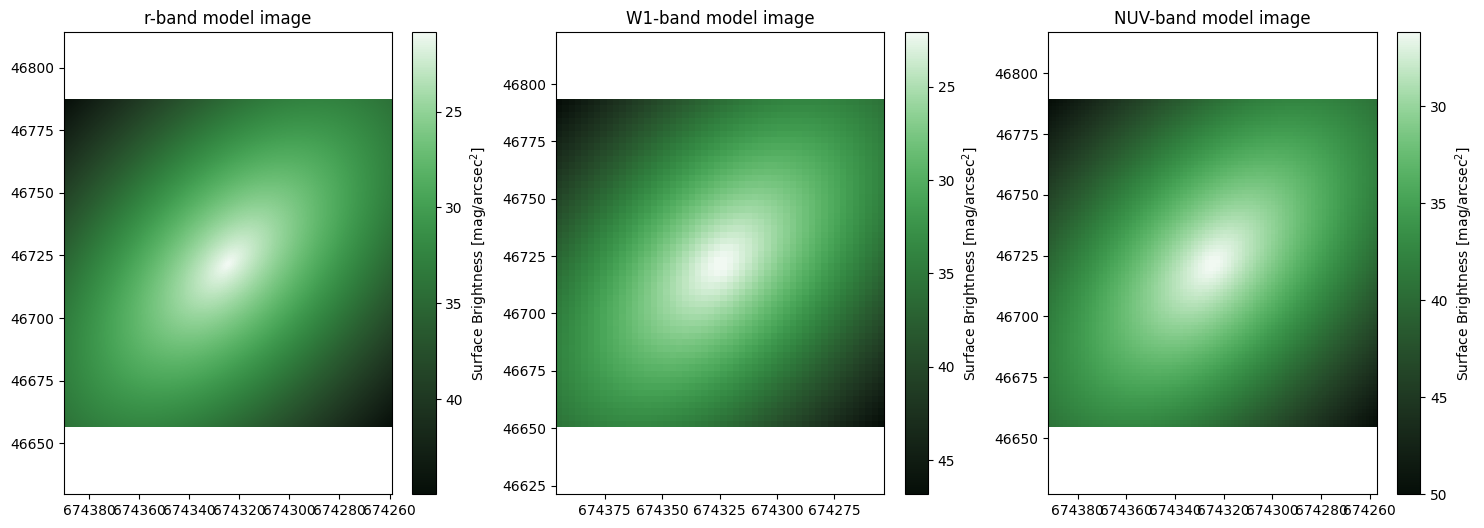

In [7]:
# here we plot the results of the fitting, notice that each band has a different PSF and pixelscale. Also, notice
# that the colour bars represent significantly different ranges since each model was allowed to fit its own Ie.
# meanwhile the center, PA, q, and Re is the same for every model.
fig1, ax1 = plt.subplots(1, 3, figsize = (18,6))
ap.plots.model_image(fig1, ax1, model_full, flipx=True)
ax1[0].set_title("r-band model image")
ax1[1].set_title("W1-band model image")
ax1[2].set_title("NUV-band model image")
plt.show()

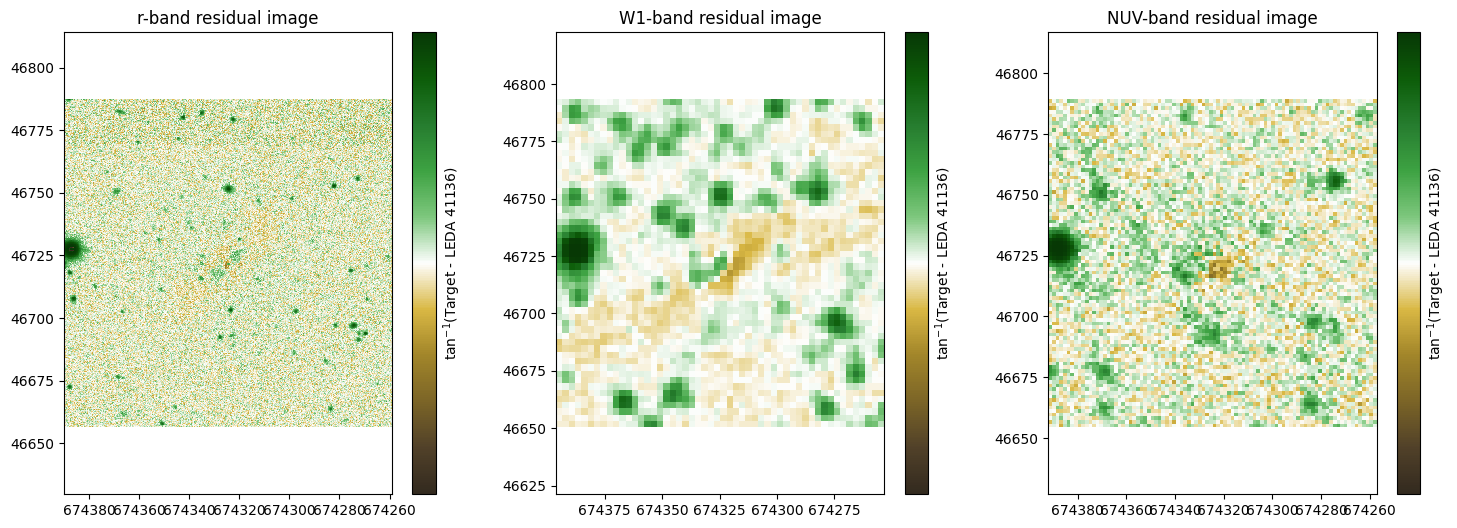

In [8]:
# We can also plot the residual images. As can be seen, the galaxy is fit in all three bands simultaneously
# with the majority of the light removed in all bands. A residual can be seen in the r band. This is likely 
# due to there being more structure in the r-band than just a sersic. The W1 and NUV bands look excellent though
fig1, ax1 = plt.subplots(1, 3, figsize = (18,6))
ap.plots.residual_image(fig1, ax1, model_full, flipx=True)
ax1[0].set_title("r-band residual image")
ax1[1].set_title("W1-band residual image")
ax1[2].set_title("NUV-band residual image")
plt.show()

In [9]:
# Save a joint model just like any other model
model_full.save("jointsave.yaml")

# This code cant run because it would create a bunch of models with names that already exist. 
# You can test it in a new file if you like
#############################################
# # Load the joint model just like any other
# model_reload = ap.models.AstroPhot_Model(
#     name = "reload LEDA 41136",
#     filename = "jointsave.yaml",
# )

# # However, targets are not saved when saving a model, so those must be re-assigned manually
# # Assign the group target
# model_reload.target = target_full 
# # Assign the sub-model targets
# model_reload.models["rband model"].target = target_r 
# model_reload.models["W1band model"].target = target_W1
# model_reload.models["NUVband model"].target = target_NUV

# # You must also update the full model window before proceeding
# model_reload.update_window()

# # Plot everything again to check its working
# fig1, ax1 = plt.subplots(2, 3, figsize = (18,12))
# ap.plots.model_image(fig1, ax1[0], model_reload, flipx=True)
# ax1[0][0].set_title("r-band model image")
# ax1[0][1].set_title("W1-band model image")
# ax1[0][2].set_title("NUV-band model image")
# ap.plots.residual_image(fig1, ax1[1], model_reload, flipx=True)
# ax1[1][0].set_title("r-band residual image")
# ax1[1][1].set_title("W1-band residual image")
# ax1[1][2].set_title("NUV-band residual image")
# plt.show()

## Joint models with multiple models

If you want to analyze more than a single astronomical object, you will need to combine many models for each image in a reasonable structure. There are a number of ways to do this that will work, though may not be as scalable. For small images, just about any arrangement is fine when using the LM optimizer. But as images and number of models scales very large, it may be neccessary to sub divide the problem to save memory. To do this you should arrange your models in a hierarchy so that AstroPhot has some information about the structure of your problem. There are two ways to do this. First, you can create a group of models where each sub-model is a group which holds all the objects for one image. Second, you can create a group of models where each sub-model is a group which holds all the representations of a single astronomical object across each image. The second method is preferred. See the diagram below to help clarify what this means.

__[JointGroupModels](https://raw.githubusercontent.com/Autostronomy/AstroPhot/main/media/groupjointmodels.png)__

Here we will see an example of a multiband fit of an image which has multiple astronomical objects.

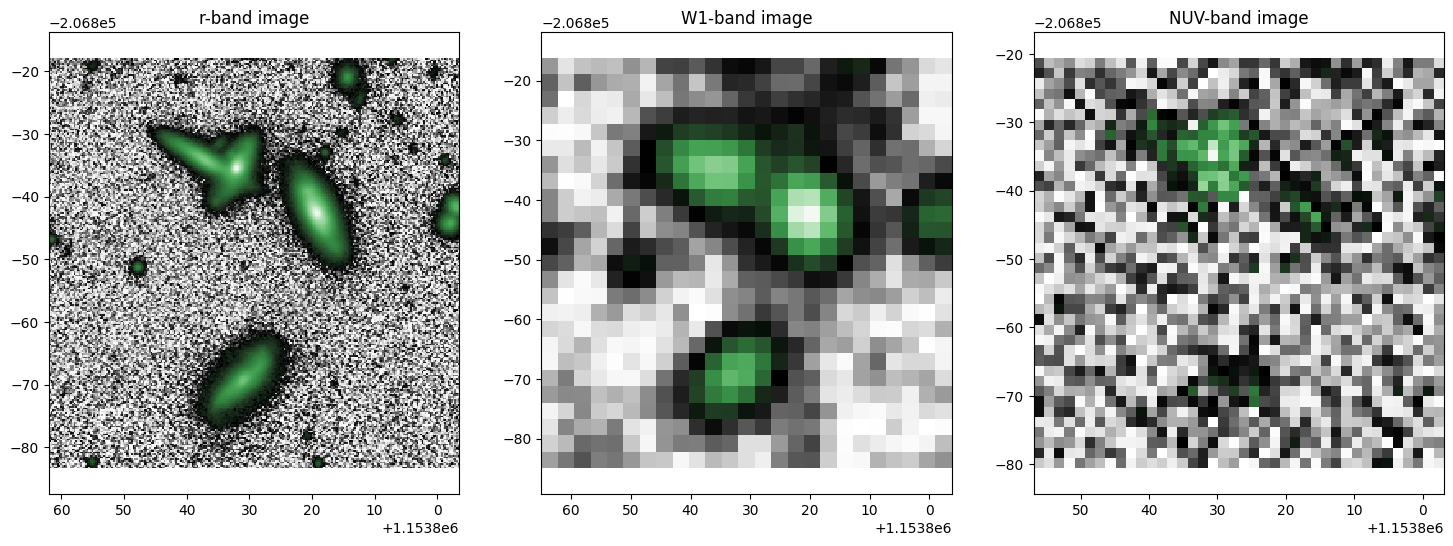

In [10]:
# First we need some data to work with, let's use another LEDA object, this time a group of galaxies: LEDA 389779, 389797, 389681

RA = 320.5003
DEC = -57.4585
# Our first image is from the DESI Legacy-Survey r-band. This image has a pixelscale of 0.262 arcsec/pixel
rsize = 250
rimg = fits.open(f"https://www.legacysurvey.org/viewer/fits-cutout?ra={RA}&dec={DEC}&size={rsize}&layer=ls-dr9&pixscale=0.262&bands=r")
target_r = ap.image.Target_Image(
    data = np.array(rimg[0].data, dtype = np.float64),
    zeropoint = 22.5,
    variance = np.ones((rsize,rsize))*0.008**2, # note that the variance is important to ensure all images are compared with proper statistical weight. Here we just use the IQR^2 of the pixel values as the variance, for science data one would use a more accurate variance value
    psf = ap.utils.initialize.gaussian_psf(1.12/2.355, 51, 0.262), # we construct a basic gaussian psf for each image by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
    wcs = WCS(rimg[0].header), 
)

# The second image is a unWISE W1 band image. This image has a pixelscale of 2.75 arcsec/pixel
wsize = 25
w1img = fits.open(f"https://www.legacysurvey.org/viewer/fits-cutout?ra={RA}&dec={DEC}&size={wsize}&layer=unwise-neo7&pixscale=2.75&bands=1")
target_W1 = ap.image.Target_Image(
    data = np.array(w1img[0].data, dtype = np.float64),
    zeropoint = 25.199,
    variance = np.ones((wsize,wsize))*4.9**2,
    psf = ap.utils.initialize.gaussian_psf(6.1/2.355, 21, 2.75),
    wcs = WCS(w1img[0].header),
)

# The third image is a GALEX NUV band image. This image has a pixelscale of 1.5 arcsec/pixel
gsize = 40
nuvimg = fits.open(f"https://www.legacysurvey.org/viewer/fits-cutout?ra={RA}&dec={DEC}&size={gsize}&layer=galex&pixscale=1.5&bands=n")
target_NUV = ap.image.Target_Image(
    data = np.array(nuvimg[0].data, dtype = np.float64),
    zeropoint = 20.08,
    variance = np.ones((gsize,gsize))*0.0007**2,
    psf = ap.utils.initialize.gaussian_psf(5.4/2.355, 21, 1.5),
    wcs = WCS(nuvimg[0].header)
)
target_full = ap.image.Target_Image_List((target_r, target_W1, target_NUV))

fig1, ax1 = plt.subplots(1, 3, figsize = (18,6))
ap.plots.target_image(fig1, ax1, target_full, flipx=True)
ax1[0].set_title("r-band image")
ax1[1].set_title("W1-band image")
ax1[2].set_title("NUV-band image")
plt.show()

There is barely any signal in the GALEX data and it would be entirely impossible to analyze on its own. With simultaneous multiband fitting it is a breeze to get relatively robust results!

Next we need to construct models for each galaxy. This is understandably more complex than in the single band case, since now we have three times the amout of data to keep track of. Recall that we will create a number of joint models to represent each astronomical object, then put them all together in a larger group model.

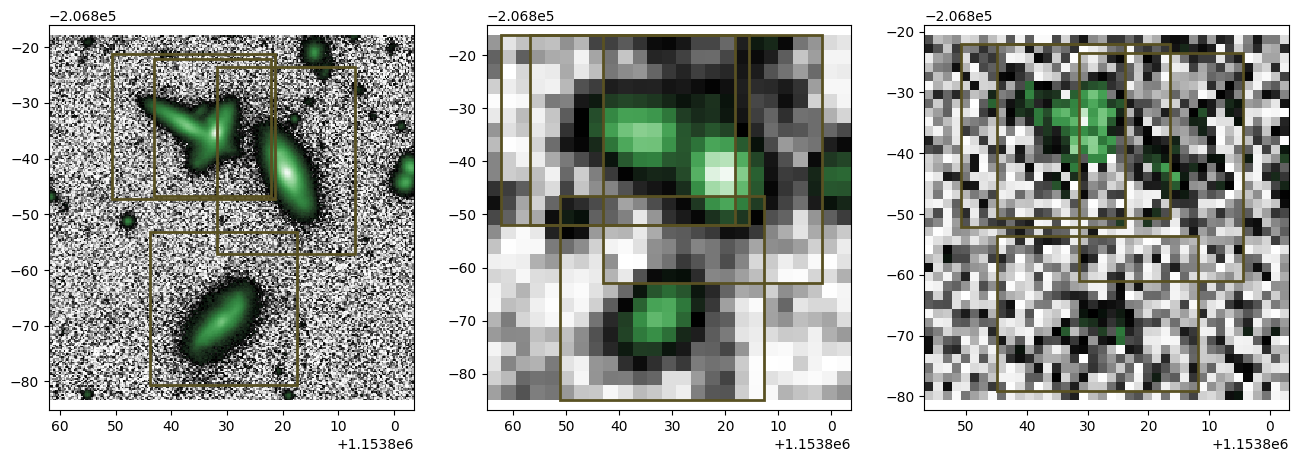

In [11]:
# Here we enter the window parameters by hand, in general one would use a segmentation map or 
# some other automated proceedure to pick out the area for many objects
windows = [
    {"r":[[72,152],[140,234]], "W1": [[3,18],[12,25]], "NUV": [[8,27],[20,39]]},
    {"r":[[43,155],[138,237]], "W1": [[1,17],[12,25]], "NUV": [[4,22],[19,39]]},
    {"r":[[115,210],[100,228]], "W1": [[8,23],[8,25]], "NUV": [[17,35],[13,38]]},
    {"r":[[69,170],[10,115]], "W1": [[5,19],[0,14]], "NUV": [[8,30],[1,18]]},
]

model_list = []

for i, window in enumerate(windows):
    # create the submodels for this object
    sub_list = []
    sub_list.append(
        ap.models.AstroPhot_Model(
            name = f"rband model {i}",
            model_type = "spline galaxy model", # we use spline models for the r-band since it is well resolved
            target = target_r,
            window = window["r"],
            psf_mode = "full",
            parameters = {"q": 0.3},
        )
    )
    sub_list.append(
        ap.models.AstroPhot_Model(
            name = f"W1band model {i}",
            model_type = "sersic galaxy model", # we use sersic models for W1 and NUV since there isn't much visible detail, a simple model is sufficient
            target = target_W1,
            window = window["W1"],
            psf_mode = "full",
            parameters = {"q": 0.3},
        )
    )
    sub_list.append(
        ap.models.AstroPhot_Model(
            name = f"NUVband model {i}",
            model_type = "sersic galaxy model",
            target = target_NUV,
            window = window["NUV"],
            psf_mode = "full",
            parameters = {"q": 0.3},
        )
    )  
    # ensure equality constraints
    # across all bands, same center, q, PA
    sub_list[1].add_equality_constraint(sub_list[0], ["center", "q", "PA"])
    sub_list[2].add_equality_constraint(sub_list[0], ["center", "q", "PA"])
    # across W1 and NUV, same n, Re
    sub_list[2].add_equality_constraint(sub_list[1], ["n", "Re"])

    # Make the multiband model for this object
    model_list.append(
        ap.models.AstroPhot_Model(
            name = f"model {i}",
            model_type = "group model",
            target = target_full,
            models = sub_list,
        )
    )
# Make the full model for this system of objects
MODEL = ap.models.AstroPhot_Model(
    name = f"full model",
    model_type = "group model",
    target = target_full,
    models = model_list,
)
fig, ax = plt.subplots(1,3, figsize = (16,5))
ap.plots.target_image(fig, ax, MODEL.target, flipx=True)
ap.plots.model_window(fig, ax, MODEL)
ax1[0].set_title("r-band image")
ax1[1].set_title("W1-band image")
ax1[2].set_title("NUV-band image")
plt.show()

In [12]:
MODEL.initialize()

result = ap.fit.LM(MODEL, verbose = 1).fit()

Chi^2: 19.842551204314265, L: 1.0
Chi^2: 17.33547603502284, L: 1.6666666666666667
Chi^2: 16.756725941601246, L: 2.777777777777778
Chi^2: 13.040587807593417, L: 0.925925925925926
Chi^2: 9.129197482307843, L: 0.308641975308642
Chi^2: 6.006381868027931, L: 0.10288065843621401
Chi^2: 4.568409242659786, L: 0.8573388203017834
Chi^2: 3.279990594399491, L: 0.28577960676726116
Chi^2: 2.947181041286043, L: 0.47629934461210194
Chi^2: 2.7029183127645013, L: 0.7938322410201698
Chi^2: 2.633133527032547, L: 1.3230537350336162
Chi^2: 2.3429984360011336, L: 0.4410179116778721
Chi^2: 2.2008416325314135, L: 0.14700597055929068
Chi^2: 1.6858581691469272, L: 0.24500995093215114
Chi^2: 1.5639567749658487, L: 0.4083499182202519
Chi^2: 1.4062565081708205, L: 0.13611663940675064
Chi^2: 1.3108154241406877, L: 0.045372213135583546
Chi^2: 1.3040653687742558, L: 0.07562035522597257
Chi^2: 1.2944020870404387, L: 0.02520678507532419
Chi^2: 1.2928302893519423, L: 0.00840226169177473
Chi^2: 1.2871922463029446, L: 0.07

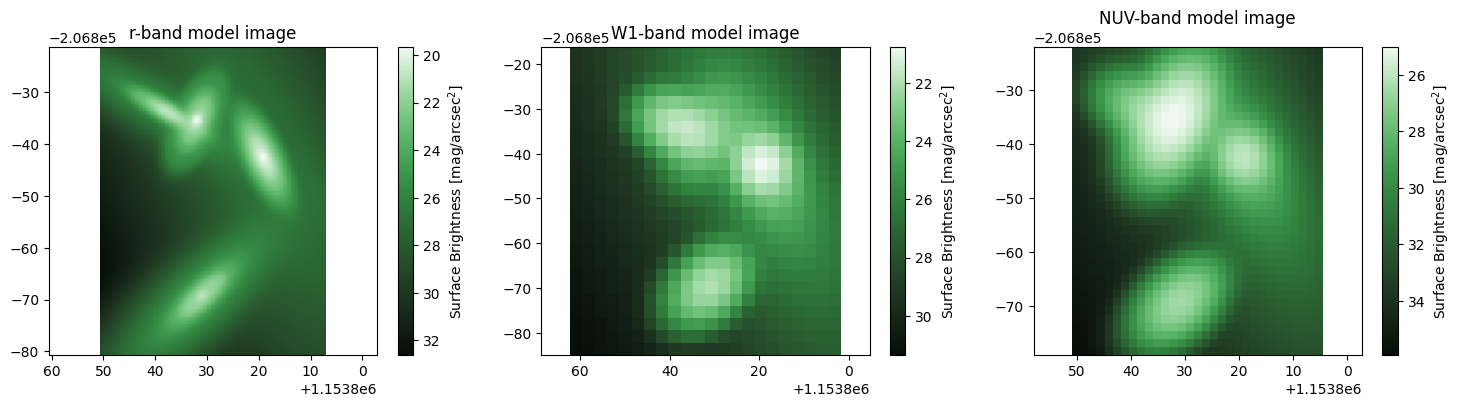

In [13]:
fig1, ax1 = plt.subplots(1, 3, figsize = (18,4))
ap.plots.model_image(fig1, ax1, MODEL, flipx=True)
ax1[0].set_title("r-band model image")
ax1[1].set_title("W1-band model image")
ax1[2].set_title("NUV-band model image")
plt.show()

The models look excellent! The power of multiband fitting lets us know that we have extracted all the available information here, no forced photometry required!

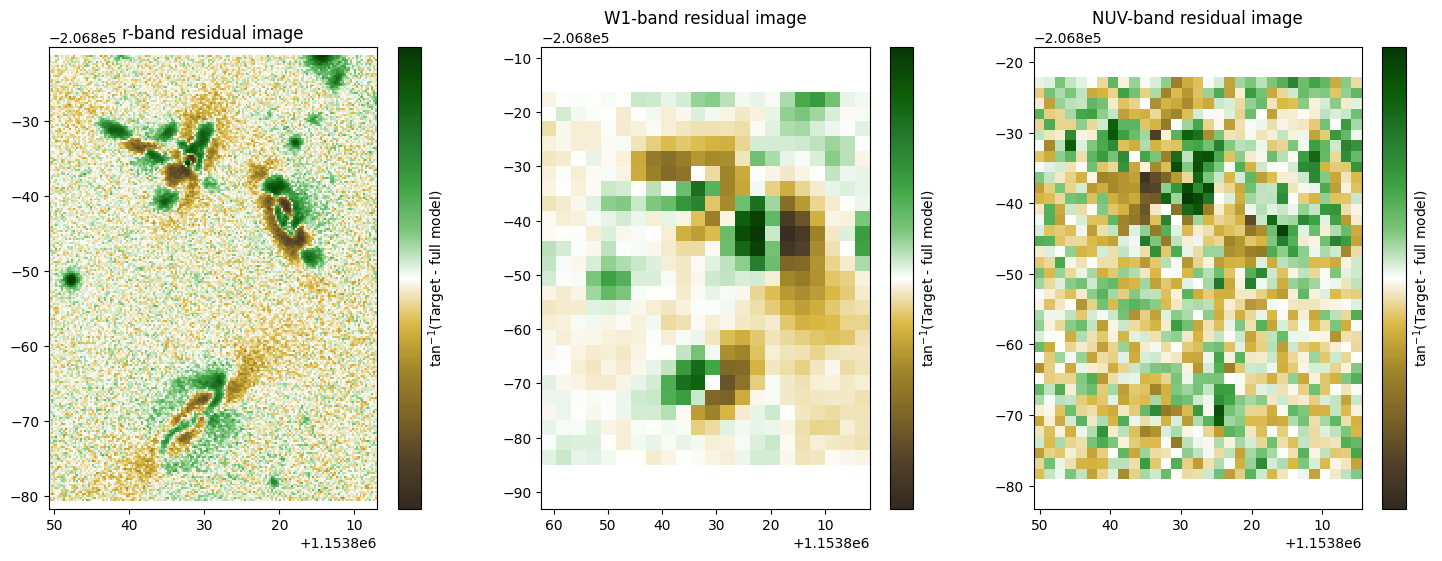

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
ap.plots.residual_image(fig, ax, MODEL, flipx=True)
ax[0].set_title("r-band residual image")
ax[1].set_title("W1-band residual image")
ax[2].set_title("NUV-band residual image")
plt.show()

Unfortunately the residuals do not look very good, in this case it is because of poor alignment in the three images. Ensuring they are all on the same coordinate system is very important. We will update this section in the future with a better example that actually gets a good result. For now, this tutorial still shows how to set up a multi-band fit and serves as a warning to make sure you have good coordinates!

### Dithered images

Note that it is not necessary to use images from different bands. Using dithered images one can effectively achieve higher resolution. It is possible to simultaneously fit dithered images with AstroPhot instead of postprocessing the two images together. This will of course be slower, but may be worthwhile for cases where extra care is needed.

### Stacked images

Like dithered images, one may wish to combine the statistical power of multiple images but for some reason it is not clear how to add them (for example they are at different rotations). In this case one can simply have AstroPhot fit the images simultaneously. Again this is slower than if the image could be combined, but should extract all the statistical power from the data!

### Time series

Some objects change over time. For example they may get brighter and dimmer, or may have a transient feature appear. However, the structure of an object may remain constant. An example of this is a supernova and its host galaxy. The host galaxy likely doesn't change across images, but the supernova does. It is possible to fit a time series dataset with a shared galaxy model across multiple images, and a shared position for the supernova, but a variable brightness for the supernova over each image. 

It is possible to get quite creative with joint models as they allow one to fix selective features of a model over a wide range of data. If you have a situation which may benefit from joint modelling but are having a hard time determining how to format everything, please do contact us!